# Fake News Pair Classification

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

## Step 1: Load Data

## 1.1 Load training data

In [2]:
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")

In [3]:
df_train.head()

,id,tid1,tid2,title1_zh,title2_zh,title1_en,title2_en,label
0,0,0,1,2017养老保险又新增两项，农村老人人人可申领，你领到了吗,警方辟谣“鸟巢大会每人领5万” 仍有老人坚持进京,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",unrelated
1,3,2,3,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",深圳GDP首超香港？深圳统计局辟谣：只是差距在缩小,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,unrelated
2,1,2,4,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",GDP首超香港？深圳澄清：还差一点点……,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,unrelated
3,2,2,5,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",去年深圳GDP首超香港？深圳统计局辟谣：还差611亿,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP topped Hong Kong last year? She...,unrelated
4,9,6,7,"""用大蒜鉴别地沟油的方法,怎么鉴别地沟油",吃了30年食用油才知道，一片大蒜轻松鉴别地沟油,"""How to discriminate oil from gutter oil by me...",It took 30 years of cooking oil to know that o...,agreed


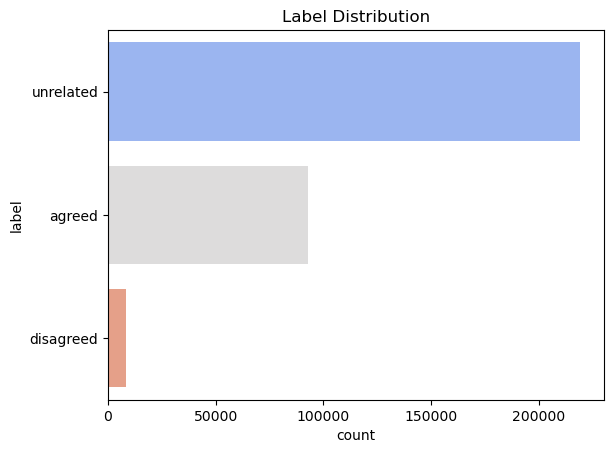

In [4]:
sns.countplot(y="label", palette="coolwarm", data=df_train).set_title('Label Distribution')
plt.show()

In [5]:
Counter(df_train.label)

Counter({'unrelated': 219313, 'agreed': 92973, 'disagreed': 8266})

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320552 entries, 0 to 320551
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         320552 non-null  int64 
 1   tid1       320552 non-null  int64 
 2   tid2       320552 non-null  int64 
 3   title1_zh  320552 non-null  object
 4   title2_zh  320545 non-null  object
 5   title1_en  320552 non-null  object
 6   title2_en  320552 non-null  object
 7   label      320552 non-null  object
dtypes: int64(3), object(5)
memory usage: 19.6+ MB


## 1.2 Data Cleaning: Remove blank headers

In [7]:
empty_title = ((df_train['title2_en'].isnull()) \
               | (df_train['title1_en'].isnull()) \
               | (df_train['title2_en'] == '') \
               | (df_train['title2_en'] == '0'))
df_train = df_train[~empty_title]

## 1.3 Data Cleaning: Remove samples with long sequences

### Avoid being unable to fit the entire gpu memory

In [8]:
MAX_LENGTH = 60
df_train = df_train[~(df_train.title1_en.apply(lambda x : len(x)) > MAX_LENGTH)]
df_train = df_train[~(df_train.title2_en.apply(lambda x : len(x)) > MAX_LENGTH)]

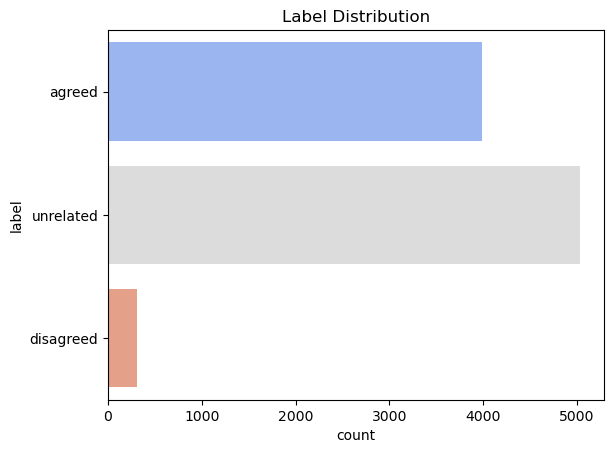

In [9]:
sns.countplot(y="label", palette="coolwarm", data=df_train).set_title('Label Distribution')
plt.show()

In [10]:
Counter(df_train.label)

Counter({'agreed': 3994, 'unrelated': 5039, 'disagreed': 311})

## 1.4 Test with 1% training data
### How much does BERT help with a small amount of labeled data

In [11]:
SAMPLE_FRAC = 0.05
df_train = df_train.sample(frac=SAMPLE_FRAC, random_state=1234)

## 1.5 Remove unnecessary data
### Remove unnecessary column & rename column name for both header

In [12]:
df_train.head()

,id,tid1,tid2,title1_zh,title2_zh,title1_en,title2_en,label
28144,28176,25191,24733,“在搬口逮住3个偷小孩的”是谣言！,警方：“临海东塍6岁小孩被拐走”是谣言,"""Catching three kids at the mouth"" is a myth!","""Six-year-old child abduction"" is a rumor.",unrelated
249388,249944,145859,145867,温州全市停水,全市范围停水是谣言，请勿再转发！,the city of wenzhou has stopped drinking water,"A citywide shutdown is a rumor, please don't r...",disagreed
206748,207170,130019,130020,无数中国女人，正被瑜伽毁掉身体……,被瑜伽毁掉的中国女人,Millions of Chinese women are being destroyed ...,A Chinese woman ruined by yoga.,agreed
258609,259183,131417,802,猴菇饼干真的养胃？,天价的猴菇养胃饼干，营养师怎么看？,Mushroom biscuits really have a stomach?,"Monkey mushroom cake, nutritionist how to see?",unrelated
286627,287225,158200,47320,竞彩足球2串1是最容易中奖的彩票吗？,博主辟谣校园足球活动玩篮球报道,Is it the easiest winning lottery ticket?,"Bloggers, rumors, campus football, basketball ...",unrelated


In [13]:
df_train = df_train.reset_index()

In [14]:
df_train.head()

,index,id,tid1,tid2,title1_zh,title2_zh,title1_en,title2_en,label
0,28144,28176,25191,24733,“在搬口逮住3个偷小孩的”是谣言！,警方：“临海东塍6岁小孩被拐走”是谣言,"""Catching three kids at the mouth"" is a myth!","""Six-year-old child abduction"" is a rumor.",unrelated
1,249388,249944,145859,145867,温州全市停水,全市范围停水是谣言，请勿再转发！,the city of wenzhou has stopped drinking water,"A citywide shutdown is a rumor, please don't r...",disagreed
2,206748,207170,130019,130020,无数中国女人，正被瑜伽毁掉身体……,被瑜伽毁掉的中国女人,Millions of Chinese women are being destroyed ...,A Chinese woman ruined by yoga.,agreed
3,258609,259183,131417,802,猴菇饼干真的养胃？,天价的猴菇养胃饼干，营养师怎么看？,Mushroom biscuits really have a stomach?,"Monkey mushroom cake, nutritionist how to see?",unrelated
4,286627,287225,158200,47320,竞彩足球2串1是最容易中奖的彩票吗？,博主辟谣校园足球活动玩篮球报道,Is it the easiest winning lottery ticket?,"Bloggers, rumors, campus football, basketball ...",unrelated


In [15]:
df_train = df_train.loc[:, ['title1_en', 'title2_en', 'label']]
df_test = df_test.loc[:, ["title1_en", "title2_en", "id"]]

In [16]:
df_train.head()

,title1_en,title2_en,label
0,"""Catching three kids at the mouth"" is a myth!","""Six-year-old child abduction"" is a rumor.",unrelated
1,the city of wenzhou has stopped drinking water,"A citywide shutdown is a rumor, please don't r...",disagreed
2,Millions of Chinese women are being destroyed ...,A Chinese woman ruined by yoga.,agreed
3,Mushroom biscuits really have a stomach?,"Monkey mushroom cake, nutritionist how to see?",unrelated
4,Is it the easiest winning lottery ticket?,"Bloggers, rumors, campus football, basketball ...",unrelated


In [17]:
df_train.columns = ['text_a', 'text_b', 'label']
df_test.columns = ["text_a", "text_b", "Id"]

In [18]:
df_train.head()

,text_a,text_b,label
0,"""Catching three kids at the mouth"" is a myth!","""Six-year-old child abduction"" is a rumor.",unrelated
1,the city of wenzhou has stopped drinking water,"A citywide shutdown is a rumor, please don't r...",disagreed
2,Millions of Chinese women are being destroyed ...,A Chinese woman ruined by yoga.,agreed
3,Mushroom biscuits really have a stomach?,"Monkey mushroom cake, nutritionist how to see?",unrelated
4,Is it the easiest winning lottery ticket?,"Bloggers, rumors, campus football, basketball ...",unrelated


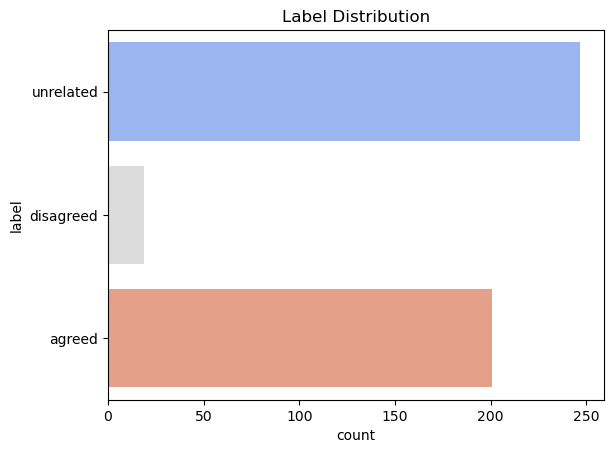

In [19]:
sns.countplot(y="label", palette="coolwarm", data=df_train).set_title('Label Distribution')
plt.show()

In [20]:
Counter(df_train.label)

Counter({'unrelated': 247, 'disagreed': 19, 'agreed': 201})

# Train validation split

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
print(len(df_train))

467


In [23]:
VALIDATION_RATIO = 0.2
RANDOM_STATE = 9527

df_train, df_val = train_test_split(df_train, test_size=VALIDATION_RATIO, random_state=RANDOM_STATE)

In [24]:
len(df_train)

373

In [25]:
len(df_val)

94

## 1.6 Save dataframe
### Save processing results as tsb for PyTorch

In [26]:
df_train.to_csv("train.tsv", sep="\t", index=False)
df_val.to_csv("val.tsv", sep="\t", index=False)
df_test.to_csv("test.tsv", sep="\t", index=False)

In [27]:
print("Number of training samples: ", len(df_train))
print("Number of validation samples: ", len(df_val))
print("Number of testing samples: ", len(df_test))

Number of training samples:  373
Number of validation samples:  94
Number of testing samples:  80126


In [28]:
df_train.head()

,text_a,text_b,label
298,Volkswagen Beetle Cut-Off,Bullshit! The Beetle won't stop.,unrelated
265,Doctor - look at the calendar: chewing gum can...,Cantalouzi eat chewing gum can cause cancer?,unrelated
376,MSG becomes stupid if you eat too much.,MSG can make people stupid.,agreed
165,The energy of a cup of yoghurt equals two Cokes?,"""The Millennium Rumors"" doesn't exist! The tru...",unrelated
397,A 100 monthly salary for the King's Glory? Is ...,"""Ai Pai Po"" Profile: It's an Offline Product.",unrelated


In [29]:
df_val.head()

,text_a,text_b,label
280,A wave of green eyes to protect your eyesight ...,Is green mobile background good for eyesight?,unrelated
253,Nanking Suing Fans Hung Suicides,A rumor about the aid fund in Jiuzhaigou,unrelated
410,The Dragon appears.,"Unknown species, we have a dragon. Look around.",agreed
405,"Pregnant babies, boys, eat more alkaline foods.",It's time to break this big rumour!,unrelated
208,"2018 Pay treasure, instant cash sales method","Ant flowers, 2018, instant cash-in-a-second.",agreed


In [30]:
df_test.head()

,text_a,text_b,Id
0,egypt 's presidential election failed to win m...,Lyon! Lyon officials have denied that Felipe F...,321187
1,A message from Saddam Hussein after he was cap...,The Top 10 Americans believe that the Lizard M...,321190
2,Will the United States wage war on Iraq withou...,A message from Saddam Hussein after he was cap...,321189
3,A message from Saddam Hussein after he was cap...,The hanging Saddam is a surrogate? This man's ...,321193
4,A message from Saddam Hussein after he was cap...,Chinese loquat loquat plaster in America? Pure...,321191


## 1.7 Model baseline

In [31]:
df_train.label.value_counts() / len(df_train)

unrelated    0.525469
agreed       0.434316
disagreed    0.040214
Name: label, dtype: float64

## 1.8 Testing samples / Training samples

In [32]:
ratio = len(df_test) / len(df_train)
print("Testing samples / Training samples= {:.1f} ".format(ratio))

Testing samples / Training samples= 214.8 


# Step 2: Convert raw text to BERT compatible input format

### My dog is cute. He likes playing.

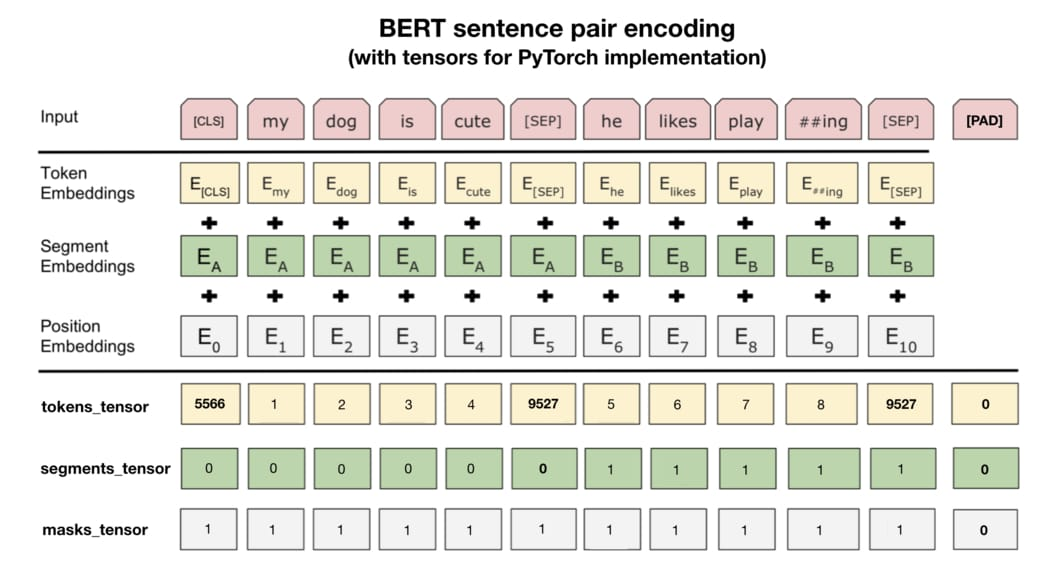

[CLS] 用於每個序列之首，Fine-tuning時用於聚集所有分類資訊，代表整個序列的語意

[SEP] 在兩個句子之間插入這個token作為區隔

[PAD] 將長度不一的輸入序列補齊，方便進行batch運算

[UNK] 沒出現在BERT字典裡的字會被這個TOKEN取代

[MASK]未知遮罩，僅在預訓練階段的扣漏字任務中會用到


https://ithelp.ithome.com.tw/articles/10260396

Masked LM: 把所有的句子，隨機將15%的詞彙置換成一個特殊的token，這個token叫做mask(克漏字問題）

Next Sentence Prediction: 給兩個句子，BERT去預測這兩個句子是接在一起的，還是不是接在一起的

In [33]:
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer
from IPython.display import clear_output

## 2.1 Get the tokenizer used by this pretrained model

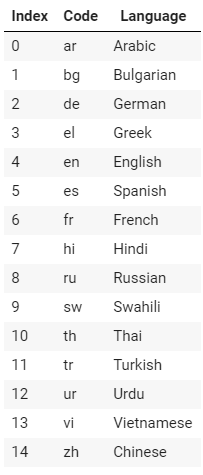

In [35]:
PRETRAINED_MODEL_NAME = 'bert-large-uncased'

In [36]:
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

In [37]:
clear_output()
print("PyTorch Version：", torch.__version__)

PyTorch Version： 1.12.1


## 2.2 Implement a Dataset that can be used to read train/test sets

這個 Dataset 每次將 tsv 裡的一筆成對句子轉換成 BERT 相容的格式，並回傳 3 個 tensors

- tokens_tensor: 兩個句子合併後的索引序列，包含 [CLS] 與 [SEP]

- segments_tensor：用來識別界限。第一句為0，第二句為1。句子之間的[SEP]為0

- label_tensor：將分類標籤轉換成類別索引的 tensor, 如果是測試集則回傳 None

- mask_tensor: 用來界定自注意力機制範圍。1 讓 BERT 關注該位置，0 則代表是 padding 不需關注

In [38]:
class FakeNewsDataset(Dataset):
    # Read the pre-processed tsv file & initialize some parameters
    def __init__(self, mode, tokenizer):
        assert mode in ["train","val","test"]  
        self.mode = mode
        
        self.df = pd.read_csv(mode + ".tsv", sep="\t").fillna("")
        self.len = len(self.df)
        self.label_map = {'agreed': 0, 'disagreed': 1, 'unrelated': 2}
        self.tokenizer = tokenizer  # BERT tokenizer
    
    # Define a function that returns a training/test data
    def __getitem__(self, idx):
        if self.mode == "test":
            text_a, text_b = self.df.iloc[idx, :2].values
            label_tensor = None
        else:
            text_a, text_b, label = self.df.iloc[idx, :].values
            
            ### label_tensor ###
            # label text to idx (tensor)
            label_id = self.label_map[label]
            label_tensor = torch.tensor(label_id)
            
        # Create BERT tokens for the first sentence and add delimiters [SEP]
        word_pieces = ["[CLS]"]
        
        tokens_a = self.tokenizer.tokenize(text_a)
        # ex: 
        # "機器學習，好好玩!" ->
        # ['機',
        #  '器',
        #  '學',
        #  '習',
        #  '，',
        #  '好',
        #  '好',
        #  '玩',
        #  '!']
        
        word_pieces += tokens_a + ["[SEP]"]
        # ex: 
        # "機器學習，好好玩!" ->
        # ['[CLS]',
        #  '機',
        #  '器',
        #  '學',
        #  '習',
        #  '，',
        #  '好',
        #  '好',
        #  '玩',
        #  '!',
        #  '[SEP]']
        
        len_a = len(word_pieces)
        
        
        # BERT tokens for the second sentence
        tokens_b = self.tokenizer.tokenize(text_b)
        word_pieces += tokens_b + ["[SEP]"]
        len_b = len(word_pieces) - len_a
        
        
        ### tokens_tensor ###
        # Convert the entire token sequence to an index sequence
        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)
        
        ### segments_tensor ###
        segments_tensor = torch.tensor([0] * len_a + [1] * len_b, 
                                        dtype=torch.long) # torch.int64
        
        return (tokens_tensor, segments_tensor, label_tensor)
    
    def __len__(self):
        return self.len
    
    

trainset = FakeNewsDataset("train", tokenizer=tokenizer)

valset = FakeNewsDataset("val", tokenizer=tokenizer)

In [39]:
train_df = pd.read_csv("train" + ".tsv", sep="\t").fillna("")
train_df.head()

,text_a,text_b,label
0,Volkswagen Beetle Cut-Off,Bullshit! The Beetle won't stop.,unrelated
1,Doctor - look at the calendar: chewing gum can...,Cantalouzi eat chewing gum can cause cancer?,unrelated
2,MSG becomes stupid if you eat too much.,MSG can make people stupid.,agreed
3,The energy of a cup of yoghurt equals two Cokes?,"""The Millennium Rumors"" doesn't exist! The tru...",unrelated
4,A 100 monthly salary for the King's Glory? Is ...,"""Ai Pai Po"" Profile: It's an Offline Product.",unrelated


In [40]:
val_df = pd.read_csv("val" + ".tsv", sep="\t").fillna("")
val_df.head()

,text_a,text_b,label
0,A wave of green eyes to protect your eyesight ...,Is green mobile background good for eyesight?,unrelated
1,Nanking Suing Fans Hung Suicides,A rumor about the aid fund in Jiuzhaigou,unrelated
2,The Dragon appears.,"Unknown species, we have a dragon. Look around.",agreed
3,"Pregnant babies, boys, eat more alkaline foods.",It's time to break this big rumour!,unrelated
4,"2018 Pay treasure, instant cash sales method","Ant flowers, 2018, instant cash-in-a-second.",agreed


In [41]:
trainset[0] 

(tensor([  101, 18817,  7813,  3013,  1011,  2125,   102, 14636,   999,  1996,
          7813,  2180,  1005,  1056,  2644,  1012,   102]),
 tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 tensor(2))

In [42]:
valset[0]

(tensor([  101,  1037,  4400,  1997,  2665,  2159,  2000,  4047,  2115,  2159,
         18743,  2813, 23298,  1012,   102,  2003,  2665,  4684,  4281,  2204,
          2005,  2159, 18743,  1029,   102]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1]),
 tensor(2))

In [43]:
# select the first sample
sample_idx = 0

# Take the original text for comparison
text_a, text_b, label = trainset.df.iloc[sample_idx].values

# Take out the converted id tensors
tokens_tensor, segments_tensor, label_tensor = trainset[sample_idx]

# tokens_tensor -> text
tokens = tokenizer.convert_ids_to_tokens(tokens_tensor.tolist())
combined_text = "".join(tokens)



print(f"""[Original text]
句子 1：{text_a}
句子 2：{text_b}
分類  ：{label}

--------------------

[Dataset tensors]
tokens_tensor  ：{tokens_tensor}

segments_tensor：{segments_tensor}

label_tensor   ：{label_tensor}

--------------------

[Recover tokens_tensors]
{combined_text}
""")

[Original text]
句子 1：Volkswagen Beetle Cut-Off
句子 2：Bullshit! The Beetle won't stop.
分類  ：unrelated

--------------------

[Dataset tensors]
tokens_tensor  ：tensor([  101, 18817,  7813,  3013,  1011,  2125,   102, 14636,   999,  1996,
         7813,  2180,  1005,  1056,  2644,  1012,   102])

segments_tensor：tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

label_tensor   ：2

--------------------

[Recover tokens_tensors]
[CLS]volkswagenbeetlecut-off[SEP]bullshit!thebeetlewon'tstop.[SEP]



# Step 3: DataLoader

In [44]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

In [45]:
"""
Implement a DataLoader to pass a mini-batch at a time
- tokens_tensors  : (batch_size, max_seq_len_in_batch)
- segments_tensors: (batch_size, max_seq_len_in_batch)
- masks_tensors   : (batch_size, max_seq_len_in_batch)
- label_ids       : (batch_size)
"""

def create_mini_batch(samples):
    
    # samples: tokens_tensor, segments_tensor, label_tensor
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]
    
    
    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples]) 
        # stack: joins (concatenates) a sequence of tensors (two or more tensors) along a new dimension
    else:
        label_ids = None
    
    ### zero pad to the same sequence length ###
    tokens_tensors = pad_sequence(tokens_tensors, 
                                  batch_first=True)
    
    # batch_first=False: (seq_len, batch, input_dim)
    # batch_first=True : (batch, seq_len, input_dim)
    
    
    segments_tensors = pad_sequence(segments_tensors, 
                                    batch_first=True)
    
    ### attention masks ###
    # Set the non-zero padding positions in tokens_tensors to 1 
    # so that BERT only pays attention to tokens in these positions
    masks_tensors = torch.zeros(tokens_tensors.shape, 
                                dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(
        tokens_tensors != 0, 1)
    
    return tokens_tensors, segments_tensors, masks_tensors, label_ids


# Using 'collate_fn' to combine the list of samples into a mini-batch
TRAIN_BATCH_SIZE = 16
trainloader = DataLoader(trainset, batch_size=TRAIN_BATCH_SIZE, 
                         collate_fn=create_mini_batch)
                        # collate_fn: implements custom batch output
    
valloader = DataLoader(valset, batch_size=TRAIN_BATCH_SIZE, 
                         collate_fn=create_mini_batch)

In [46]:
data = next(iter(trainloader))

tokens_tensors, segments_tensors, \
    masks_tensors, label_ids = data


print(f"""
tokens_tensors.shape   = {tokens_tensors.shape} 
{tokens_tensors}
------------------------
segments_tensors.shape = {segments_tensors.shape}
{segments_tensors}
------------------------
masks_tensors.shape    = {masks_tensors.shape}
{masks_tensors}
------------------------
label_ids.shape        = {label_ids.shape}
{label_ids}
""")


tokens_tensors.shape   = torch.Size([16, 34]) 
tensor([[  101, 18817,  7813,  3013,  1011,  2125,   102, 14636,   999,  1996,
          7813,  2180,  1005,  1056,  2644,  1012,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0],
        [  101,  3460,  1011,  2298,  2012,  1996,  8094,  1024, 17492, 16031,
          2064,  3426,  4456,  1029,   102,  2064,  9080,  7140,  5831,  4521,
         17492, 16031,  2064,  3426,  4456,  1029,   102,     0,     0,     0,
             0,     0,     0,     0],
        [  101,  5796,  2290,  4150,  5236,  2065,  2017,  4521,  2205,  2172,
          1012,   102,  5796,  2290,  2064,  2191,  2111,  5236,  1012,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0],
        [  101,  1996,  2943,  1997,  1037,  2452,  1997, 10930,  5603, 19585,
         19635,  2048, 14492,  2015,  1029,   10

# Step 4: Add a new layer to the downstream task model on top of BERT

In [47]:
from transformers import BertForSequenceClassification

In [48]:
# Load a model that can do Chinese multi-classification task, n_class = 3

PRETRAINED_MODEL_NAME = 'bert-large-uncased'
NUM_LABELS = 3

model = BertForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

In [49]:
clear_output()

# modules
print("""
name            module
----------------------""")
for name, module in model.named_children():
    if name == "bert":
        for n, _ in module.named_children():
            print(f"{name}:{n}")
    else:
        print("{:15} {}".format(name, module))


name            module
----------------------
bert:embeddings
bert:encoder
bert:pooler
dropout         Dropout(p=0.1, inplace=False)
classifier      Linear(in_features=1024, out_features=3, bias=True)


In [50]:
model.config

BertConfig {
  "_name_or_path": "bert-large-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [51]:
def get_predictions(model, dataloader, compute_acc=False):
    predictions = None
    correct = 0
    total = 0
      
    with torch.no_grad():
        for data in dataloader:
            
            if next(model.parameters()).is_cuda:
                data = [t.to("cuda:0") for t in data if t is not None]
            
            
            
            tokens_tensors, segments_tensors, masks_tensors = data[:3]
            outputs = model(input_ids=tokens_tensors, 
                            token_type_ids=segments_tensors, 
                            attention_mask=masks_tensors)
            
            logits = outputs[0]
            _, pred = torch.max(logits.data, 1)
            
            
            if compute_acc:
                labels = data[3]
                total += labels.size(0)
                correct += (pred == labels).sum().item()
                
            
            if predictions is None:
                predictions = pred
            else:
                predictions = torch.cat((predictions, pred))
    
    if compute_acc:
        acc = correct / total
        return predictions, acc
    return predictions
    

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
model = model.to(device)

_, acc = get_predictions(model, trainloader, compute_acc=True)
print("classification acc:", acc)

device: cuda:0
classification acc: 0.5013404825737265


In [52]:
def get_learnable_params(module):
    return [p for p in module.parameters() if p.requires_grad]
     
model_params = get_learnable_params(model)
clf_params = get_learnable_params(model.classifier)

print(f"""
The amount of parameters of the entire classification model：{sum(p.numel() for p in model_params)}
The amount of parameters for the linear classifier：{sum(p.numel() for p in clf_params)}
""")


The amount of parameters of the entire classification model：335144963
The amount of parameters for the linear classifier：3075



In [53]:
list(model.named_parameters())


[('bert.embeddings.word_embeddings.weight',
  Parameter containing:
  tensor([[-0.0419,  0.0022, -0.0314,  ..., -0.0146, -0.0358, -0.0929],
          [-0.0434, -0.0115, -0.0065,  ..., -0.0273, -0.0310, -0.1084],
          [-0.0622, -0.0114, -0.0073,  ..., -0.0247, -0.0334, -0.0915],
          ...,
          [ 0.0239, -0.0083, -0.0061,  ...,  0.0176,  0.0214, -0.0763],
          [-0.0468, -0.0018,  0.0020,  ..., -0.0173, -0.0243, -0.1124],
          [-0.0185, -0.0369, -0.0623,  ..., -0.0054, -0.0412, -0.0847]],
         device='cuda:0', requires_grad=True)),
 ('bert.embeddings.position_embeddings.weight',
  Parameter containing:
  tensor([[ 0.0041, -0.0139, -0.0263,  ..., -0.0042, -0.0212,  0.0148],
          [ 0.0097,  0.0067, -0.0287,  ...,  0.0003,  0.0051,  0.0049],
          [ 0.0005, -0.0129, -0.0019,  ..., -0.0006,  0.0247,  0.0181],
          ...,
          [ 0.0047,  0.0026,  0.0021,  ...,  0.0092, -0.0113,  0.0185],
          [-0.0161, -0.0068,  0.0181,  ...,  0.0040, -0.0194,

In [54]:
from pytorch_pretrained_bert.optimization import BertAdam

In [55]:
%%time

# train mode
model.train()


EPOCHS = 10  # 6

# Adam Optim
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']


num_train_optimization_steps = int(len(trainset) / TRAIN_BATCH_SIZE / 1) * EPOCHS

optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

optimizer = BertAdam(optimizer_grouped_parameters,
                             lr=1e-5,
                             warmup=0.1,
                             t_total=num_train_optimization_steps) # BertAdam


training_loss = []
training_acc = []

val_loss = []
val_acc = []



for epoch in range(EPOCHS):
    
    running_loss = 0.0
    for data in trainloader:
        
        tokens_tensors, segments_tensors, \
        masks_tensors, labels = [t.to(device) for t in data]

        # gradient reset to zero
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors, 
                        labels=labels)

        loss = outputs[0]
        # backward
        loss.backward()
        optimizer.step()
        

        # batch loss
        running_loss += loss.item()
        
    # acc
    _, acc = get_predictions(model, trainloader, compute_acc=True)
    
    training_loss.append(running_loss/len(trainloader))
    training_acc.append(acc)
    
    
    print('[epoch %d] training_loss: %.3f, training_acc: %.3f' %
          (epoch + 1, running_loss/len(trainloader), acc))
    
    #####################################################################
    
    running_loss = 0.0
    for data in valloader:
        
        tokens_tensors, segments_tensors, \
        masks_tensors, labels = [t.to(device) for t in data]

        # gradient reset to zero
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors, 
                        labels=labels)

        loss = outputs[0]
        # backward
        # loss.backward()
        # optimizer.step()


        # batch loss
        running_loss += loss.item()
        
        
    # acc
    _, acc = get_predictions(model, trainloader, compute_acc=True)
    
    val_loss.append(running_loss/len(valloader))
    val_acc.append(acc)
    
    
    print('          val_loss: %.3f, val_acc: %.3f' %
          (running_loss/len(valloader), acc))
    
    print("----------------------------------------------------")
    

/home/bakerchen/.conda/envs/ML_training/lib/python3.7/site-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484801627/work/torch/csrc/utils/python_arg_parser.cpp:1174.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


[epoch 1] training_loss: 0.961, training_acc: 0.812
          val_loss: 0.766, val_acc: 0.818
----------------------------------------------------
[epoch 2] training_loss: 0.521, training_acc: 0.920
          val_loss: 0.790, val_acc: 0.914
----------------------------------------------------
[epoch 3] training_loss: 0.300, training_acc: 0.946
          val_loss: 0.955, val_acc: 0.957
----------------------------------------------------
[epoch 4] training_loss: 0.177, training_acc: 0.965
          val_loss: 1.035, val_acc: 0.965
----------------------------------------------------
[epoch 5] training_loss: 0.165, training_acc: 0.960
          val_loss: 1.121, val_acc: 0.957
----------------------------------------------------
[epoch 6] training_loss: 0.167, training_acc: 0.960
          val_loss: 0.972, val_acc: 0.957
----------------------------------------------------
[epoch 7] training_loss: 0.145, training_acc: 0.960
          val_loss: 1.219, val_acc: 0.962
------------------------

Training beyond specified 't_total'. Learning rate multiplier set to 0.0. Please set 't_total' of WarmupLinearSchedule correctly.
Training beyond specified 't_total'. Learning rate multiplier set to 0.0. Please set 't_total' of WarmupLinearSchedule correctly.
Training beyond specified 't_total'. Learning rate multiplier set to 0.0. Please set 't_total' of WarmupLinearSchedule correctly.
Training beyond specified 't_total'. Learning rate multiplier set to 0.0. Please set 't_total' of WarmupLinearSchedule correctly.
Training beyond specified 't_total'. Learning rate multiplier set to 0.0. Please set 't_total' of WarmupLinearSchedule correctly.
Training beyond specified 't_total'. Learning rate multiplier set to 0.0. Please set 't_total' of WarmupLinearSchedule correctly.
Training beyond specified 't_total'. Learning rate multiplier set to 0.0. Please set 't_total' of WarmupLinearSchedule correctly.
Training beyond specified 't_total'. Learning rate multiplier set to 0.0. Please set 't_to

[epoch 10] training_loss: 0.131, training_acc: 0.971
          val_loss: 1.159, val_acc: 0.962
----------------------------------------------------
CPU times: user 52.2 s, sys: 6.42 s, total: 58.6 s
Wall time: 58.6 s


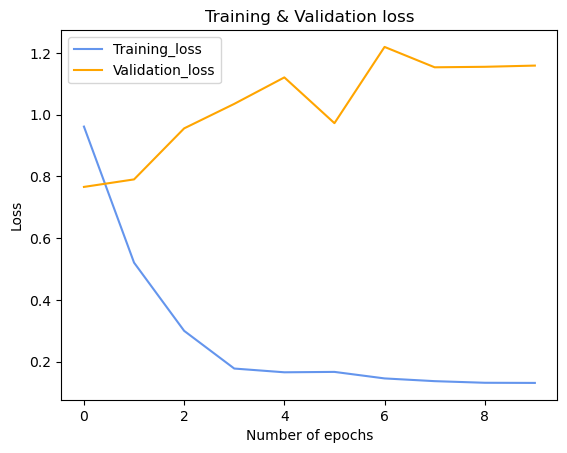

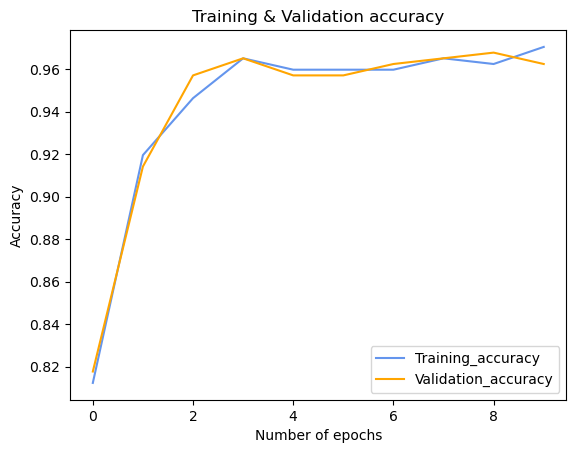

In [56]:
# visualization
plt.plot(training_loss, color='cornflowerblue', label='Training_loss')
plt.plot(val_loss, color='orange', label='Validation_loss')
plt.title('Training & Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(training_acc, color='cornflowerblue', label='Training_accuracy')
plt.plot(val_acc, color='orange', label='Validation_accuracy')
plt.title('Training & Validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# https://leemeng.tw/attack_on_bert_transfer_learning_in_nlp.html